# Model Ensemble: Toy example

1. The goal of this exercise is to combine different models and get uncertainty of estimates using an **ensemble model**.
2. We predict the median LE (data = `LA_uncertainty.dta`) just to simplify. 
3. We use three different regression models: Ridge, Random Forest, K-Neighbors. We can include others later (e.g., logistic or boxcox).
4. The estimate is the first different in LE of increasing GDP by one standard deviation. 

In [2]:
# load packages
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.utils import resample
import sklearn.metrics as met

import numpy as np
import pandas as pd
import collections

from sklearn_pandas import DataFrameMapper, cross_val_score
from utils import utils as f # my functions
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline

Here it is the definition of classes and models:

In [220]:
# define model transformers

# class LinearTransformer(LinearRegression, TransformerMixin):

#     def transform(self, X, *_):
#         return self.predict(X).reshape(-1,1)
    
class RidgeTransformer(Ridge, TransformerMixin):

    def transform(self, X, *_):
        pred = self.predict(X)
        if len(pred.shape) > 1:
            return self.predict(X)
        else:
            return self.predict(X).reshape(-1,1)

class RandomForestTransformer(RandomForestRegressor, TransformerMixin):

    def transform(self, X, *_):
        pred = self.predict(X)
        if len(pred.shape) > 1:
            return self.predict(X)
        else:
            return self.predict(X).reshape(-1,1)

class KNeighborsTransformer(KNeighborsRegressor, TransformerMixin):

    def transform(self, X, *_):
        pred = self.predict(X)
        if len(pred.shape) > 1:
            return self.predict(X)
        else:
            return self.predict(X).reshape(-1,1)

We combine predictions generated from these models and use them to **predict** the actual outcome. We weight those predictions using linear regression, although we could use any other model (e.g., random forest, xgboost). For now, let's keep it simple. 

- For Ridge regression, GDP is first standardized, and then polynomial transformations of features were computed.
- Random Forest and K-Neighbors use the default set up. 

In [205]:
# function to create model
def build_model():

#     linear_regression = Pipeline(steps=[
#         ('scaler', StandardScaler()),
#         ('linear', LinearTransformer())
#     ])

    ridge_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly_feats', PolynomialFeatures()),
        ('ridge', RidgeTransformer())
    ])
    
    pred_union = FeatureUnion(
        transformer_list=[
#             ('linear_reg', linear_regression),
            ('ridge', ridge_transformer),
            ('rand_forest', RandomForestTransformer()),
            ('knn', KNeighborsTransformer())
        ],
    )

    # return combination of predictions
    model = Pipeline(steps=[
        ('pred_union', pred_union),
        ('lin_regr', LinearRegression()) # linear combination
    ])

    return model

# Uncertainty LE estimates

We resample 1000 distribution of LE estimates. The sampling is proportional to columns `pr_est`: values with highest `pr_est` have a highest change to be in the sample.  

In [188]:
df = pd.read_stata('../data/LA_uncertainty.dta')

In [189]:
df = df.dropna(subset=['median', 'gdp_pc'])

In [190]:
df.reset_index(drop=True, inplace=True)

In [70]:
# function to sample LE estimates (1000)
def sampling_le(data, estimate='^est', prob='^pr_est', samples=1000): 
    
    d = data.copy()
    est = d.filter(regex=estimate)
    prob = d.filter(regex=prob)
    nrows = est.shape[0]
    
    matrix = np.empty(shape=[nrows, samples])
    
    for s in range(samples):
        if s % 200 == 0:
            print('Iteration: ' + str(s))
        col = []
        for row in range(nrows):
            e = est.iloc[row,:].dropna()
            if len(e)==1:
                col.append(e.values)
            if len(e)>1:
                names = list(e.index)
                for n in names: 
                    names[names.index(n)] = 'pr_'+ n
                p = prob.loc[row,names].values
                col.append(e.sample(n=1, weights=p).values)
        matrix[:,s] = col
    return matrix

In [71]:
m = sampling_le(df)

Iteration: 0
Iteration: 200
Iteration: 400
Iteration: 600
Iteration: 800


In [372]:
# checking sampling
collections.Counter(m[50,:])

Counter({54.239997863769531: 389, 58.87591552734375: 611})

In [398]:
df.loc[(df.ctry=='Brazil') & (df.year==1970), ['est12', 'est13', 'pr_est12', 'pr_est13']]

,est12,est13,pr_est12,pr_est13
50,54.239998,58.875916,0.65,0.95


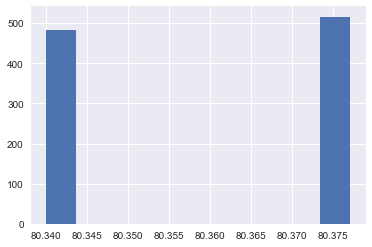

In [402]:
# example
plt.hist(m[120,:]);

# Example

### LE estimates uncertaintly 

Using 1000 distributions of LE estimates, let's see how estimates behave (only LE uncertaintly) using the counterfactual + 1 SD gdp.

In [192]:
X = df['gdp_pc'].values.reshape(-1,1)
country = df['ctry']
# year = df['year']

In [206]:
# define training set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    m, 
                                                    test_size=0.20, 
                                                   random_state=123)

In [273]:
# instance of model
model = build_model()

In [293]:
# le estimate uncertainty
nrows = X_train.shape[0]
samples = 1000
pred_mat = np.empty(shape=[nrows, samples])
pred_mat_cf = np.empty(shape=[nrows, samples])
for s in range(samples):
    if s % 200 == 0:
        print('Iteration: ' + str(s))
    model.fit(X_train, y_train[:,s])
    pred_train = model.predict(X_train)
    pred_train_cf = model.predict(X_train + np.std(X_train))
    pred_mat[:,s] = pred_train
    pred_mat_cf[:,s] = pred_train_cf

Iteration: 0
Iteration: 200
Iteration: 400
Iteration: 600
Iteration: 800


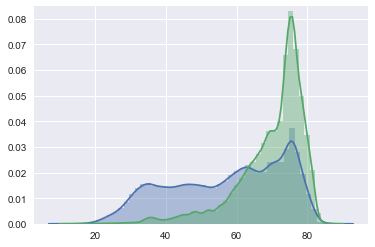

In [312]:
sns.distplot(pred_mat.flatten(), label='pred observed le')
sns.distplot(pred_mat_cf.flatten(), label='counterfactual');
plt.add_legend()

No big variability due to differences in the LE estimates.

In [403]:
# compute first difference and average
diff = (pred_mat_cf - pred_mat).mean(axis=0) # estimating a mean

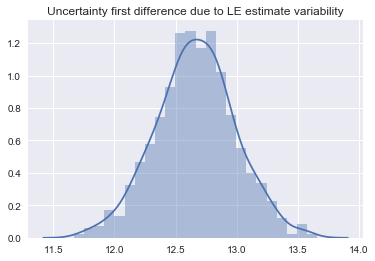

In [358]:
sns.distplot(diff)
plt.title('Uncertainty first difference due to LE estimate variability');

### Model Uncertainty

The easiest way to do it is to bootstrap estimates of the **first difference**. I am not sure this is *model uncertainty*, but anyways, below a pretty straightforward function to do it.

In [347]:
# bootstrap function
def bootstrap(estimator, X, y, samples=1000, sample_size=1.0): 
    
    # list to save results
    stats = []
    nrows = y.shape[0]
    
    # loop
    for s in range(0, samples):
#         if (s % 20 == 0): 
#             print('... Iteration bootstrap: ', str(s))
        idx = np.random.choice(nrows, int(len(y)*sample_size), replace=True)
        ty = y[idx]
        tX = X[idx]
        
        model.fit(tX, ty)
        pred = model.predict(tX)
        pred_cf = model.predict(tX + np.std(tX))
        stats.append(np.mean(pred_cf - pred))
    return stats

In [ ]:
# run bootstrap for 1000 LE estimates
bootstraps = 1000
le_estimates = 1000
diff_mat = np.empty(shape=[bootstraps, le_estimates])

for v in range(le_estimates):
    if v % 10 == 0:
        print('Iteration estimate: ' + str(v))
    y_temp = y_train[:,v]
    diff_mat[:,v] = bootstrap(model, X_train, y_temp, samples=bootstraps)

Iteration estimate: 0


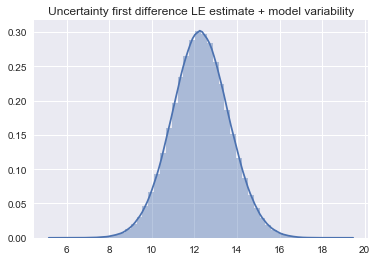

In [362]:
sns.distplot(diff_mat.flatten())
plt.title('Uncertainty first difference LE estimate + model variability');